# Previsão de Séries Temporais com TensorFlow

Este notebook demonstra:
1. **Leitura e subamostragem** de dados (exemplo: de 10 min para 1 hora).
2. **Limpeza** e **Engenharia de Atributos** (ex.: vetor de vento, periodicidade).
3. **Normalização** e divisão em **treino/validação/teste**.
4. Criação de **janelas** (`WindowGenerator`).
5. **Modelos**:
   - Baselines (MultiStepLastBaseline, RepeatBaseline)
   - Modelos single-shot (Linear, Dense, CNN, LSTM)
   - Modelo autoregressivo (FeedBack)
6. **Comparação** de desempenhos.

Ao final, teremos uma visão geral de como montar um pipeline de previsão multi-step em TensorFlow.

## 1) Importação de Bibliotecas

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True
sns.set_style('whitegrid')

print("Versão do TensorFlow:", tf.__version__)

Versão do TensorFlow: 2.18.0


## 2) Leitura do CSV e Subamostragem
Supondo que temos um arquivo CSV com leituras a cada 10 minutos, mas queremos transformar em leituras de 1h. Fatiamos (slice) a partir do índice 5, pegando 1 linha a cada 6. Assim, o DataFrame final terá registros de hora em hora.

In [97]:
# Exemplo de caminho para o CSV (ajuste para o seu caso)
csv_path = 'jena_climate_2009_2016.csv'

# Leitura
df = pd.read_csv(csv_path)
print("Shape original:", df.shape)

# Subamostragem: a cada 6 linhas, começando no índice 5
df = df[5::6]
print("Shape após subamostragem (1h):", df.shape)

# Visualizar as primeiras linhas
df.head()

Shape original: (420551, 15)
Shape após subamostragem (1h): (70091, 15)


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Colunas:

- `p (mbar)`: pressão atmosférica em milibares.
- `T (degC)`: temperatura em graus Celsius.
- `Tpot (K)`: temperatura potencial em Kelvin.
- `Tdew (degC)`: temperatura de orvalho em graus Celsius.
- `rh (%)`: umidade relativa em porcentagem.
- `...` (demais colunas listadas).

### Convertendo Datas para `datetime`
Removemos a coluna `'Date Time'` do `DataFrame` e salvamos em `date_time` para trabalhar separadamente.

In [98]:
date_time = pd.to_datetime(
    df.pop('Date Time'),
    format='%d.%m.%Y %H:%M:%S'  # ajuste se necessário
)

print("Exemplo de date_time:", date_time.head())
df.head()

Exemplo de date_time: 5    2009-01-01 01:00:00
11   2009-01-01 02:00:00
17   2009-01-01 03:00:00
23   2009-01-01 04:00:00
29   2009-01-01 05:00:00
Name: Date Time, dtype: datetime64[ns]


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


## 3) Exploração e Limpeza de Dados
### 3.1. Estatística Inicial

In [99]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


### 3.2. Visualização Inicial
- `['T (degC)', 'p (mbar)', 'rho (g/m**3)']`: escolhemos temperatura, pressão e densidade para exemplificar a evolução dessas variáveis no tempo.

- No segundo grafico, pegamos apenas as 480 primeiras linhas (ou seja, 480 horas ≈ 20 dias), para ver o comportamento em um intervalo menor. Dessa forma, é possível inspecionar em detalhe como as variáveis mudam em um curto período.

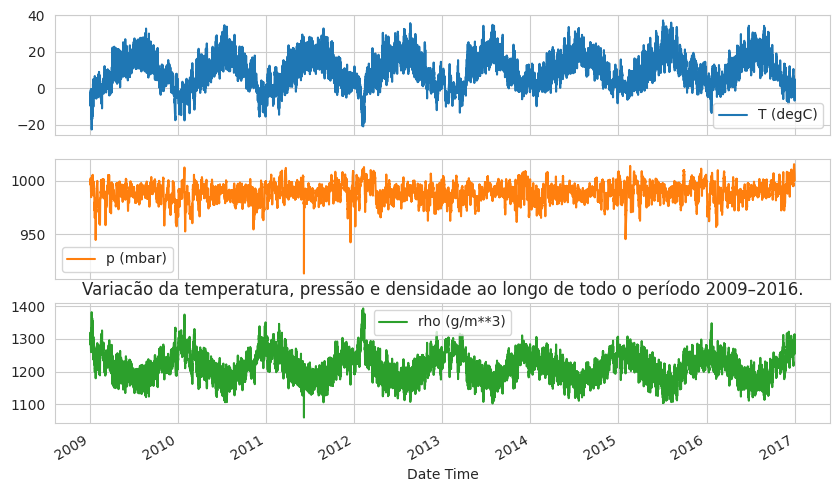

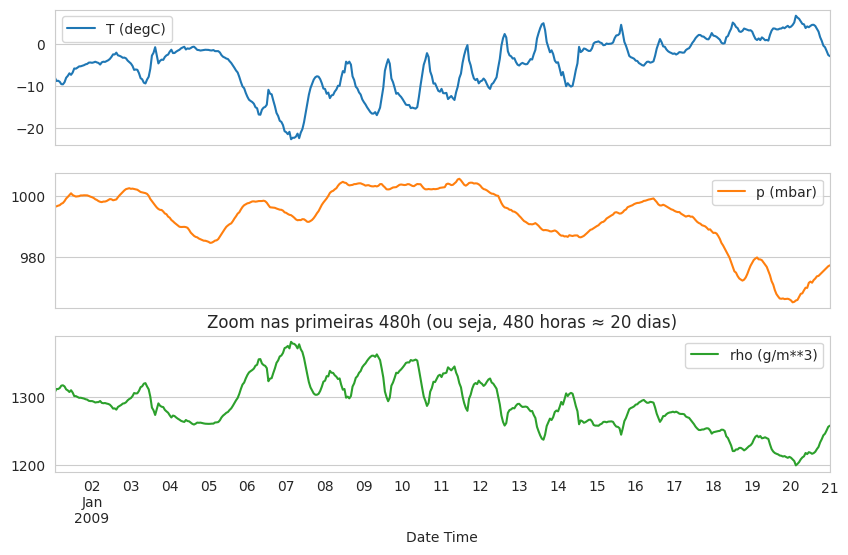

In [100]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols].copy()
plot_features.index = date_time
plot_features.plot(subplots=True)
plt.title("Variacão da temperatura, pressão e densidade ao longo de todo o período 2009–2016.")
plt.show()

# Zoom em 480h
plot_features_zoom = df[plot_cols][:480].copy()
plot_features_zoom.index = date_time[:480]
plot_features_zoom.plot(subplots=True)
plt.title("Zoom nas primeiras 480h (ou seja, 480 horas ≈ 20 dias)")
plt.show()

### 3.3. Tratando Valores Anômalos (ex.: -9999)
Descobrimos atraves do `.describe()` que `wv (m/s)` e `max. wv (m/s)` possuem valores mínimos em -9999.0. Isso indica um valor provavelmente usado para representar dados ausentes (missing data ou erroneous data).

In [101]:
if 'wv (m/s)' in df.columns:
    bad_wv = df['wv (m/s)'] == -9999.0
    df.loc[bad_wv, 'wv (m/s)'] = 0.0
if 'max. wv (m/s)' in df.columns:
    bad_max_wv = df['max. wv (m/s)'] == -9999.0
    df.loc[bad_max_wv, 'max. wv (m/s)'] = 0.0

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


## 4) Engenharia de Atributos
Antes de construir e treinar modelos, é importante engenheirar os atributos (ou features) para facilitar o processo de aprendizado. Duas partes importantes discutidas no tutorial são:

- Transformação dos dados de vento
- Transformação do tempo (coluna Date Time)

### 4.1. Vetores de Vento (Wx, Wy)
Ao invés de lidar com ângulos, transformamos `(velocidade, direção)` em `(Wx, Wy)`. A motivação é que trabalhar com direções em graus (0° a 360°) pode confundir o modelo, pois 360° e 0° representam a mesma direção. Além disso, se o vento não estiver soprando, o ângulo deixa de ser relevante.

In [102]:
import numpy as np

if 'wd (deg)' in df.columns and 'wv (m/s)' in df.columns:
    wv = df.pop('wv (m/s)')
    max_wv = df.pop('max. wv (m/s)') if 'max. wv (m/s)' in df.columns else None

    wd_rad = df.pop('wd (deg)') * np.pi/180

    df['Wx'] = wv*np.cos(wd_rad)
    df['Wy'] = wv*np.sin(wd_rad)

    if max_wv is not None:
        df['max Wx'] = max_wv*np.cos(wd_rad)
        df['max Wy'] = max_wv*np.sin(wd_rad)

    print("Convertido direção e velocidade em (Wx, Wy).")

Convertido direção e velocidade em (Wx, Wy).


### 4.2. Capturando Periodicidade Diária e Anual
A coluna de data/hora em si não é diretamente útil como string ou mesmo em segundos, pois se trata de dados sazonais (com variação diária e anual).

#### Sinal Diário:
- Geramos `Day sin/cos` com base em `timestamp_s` (tempo em segundos). Day sin e Day cos usam timestamp_s * (2π / day), que percorre 2π a cada 24h. Assim, cada dia mapeia um ciclo completo de seno e cosseno.
- O modelo pode, então, aprender facilmente a hora do dia: 0h e 24h correspondem a (sin=0, cos=1), meio-dia (~12h) vira (sin=1, cos=0), etc.

#### Sinal Anual:
- `Year sin/cos` fazem o mesmo, mas para o período de 1 ano.
- Assim, ao longo de ~365 dias, `timestamp_s` percorre `2π` no seno e cosseno, capturando a sazonalidade anual (por ex., verão/inverno).

In [103]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60 # segundos em um dia
year = 365.2425*day #segundos em um ano

df['Day sin'] = np.sin(timestamp_s*(2*np.pi/day))
df['Day cos'] = np.cos(timestamp_s*(2*np.pi/day))
df['Year sin'] = np.sin(timestamp_s*(2*np.pi/year))
df['Year cos'] = np.cos(timestamp_s*(2*np.pi/year))

print("Criadas colunas de periodicidade diária e anual.")
df.head()

Criadas colunas de periodicidade diária e anual.


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168,-0.614587,-0.138503,0.258819,0.965926,0.010049,0.999950
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701,-0.619848,-0.112645,0.500000,0.866025,0.010766,0.999942
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,0.707107,0.707107,0.011483,0.999934
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603,-0.190000,-0.329090,0.866025,0.500000,0.012199,0.999926
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292,-0.810044,0.343843,0.965926,0.258819,0.012916,0.999917


Text(0.5, 1.0, 'Time of day signal')

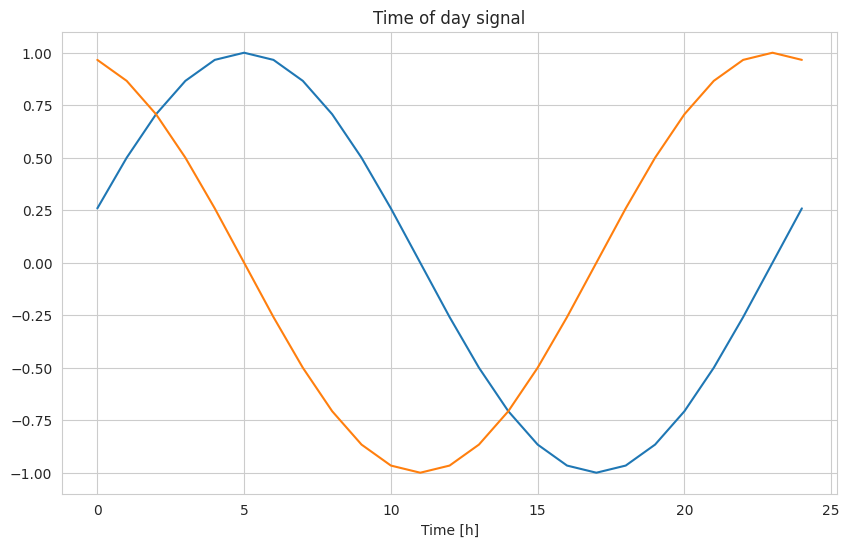

In [104]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Ao plotar as primeiras 25 amostras de `Day sin` e `Day cos` observamos curvas de seno e cosseno defasadas, confirmando essa representação periódica.

- Para reforçar essa análise, podemos usar Transformada Rápida de Fourier (FFT) e observar picos em frequências diárias (1/dia) e anuais (1/ano).
- `tf.signal.rfft(df['T (degC)'])` dá a transformada real dos valores de temperatura; ao plotar `np.abs(fft)` em escala logarítmica, vê-se picos nas frequências de 1/ano e 1/dia, como esperado para dados climáticos.

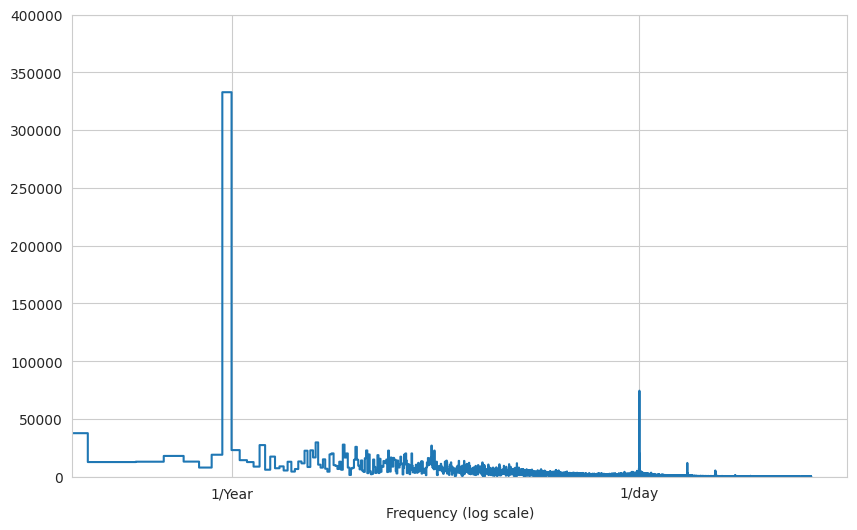

In [105]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

## 5)Divisão em Treino/Validação/Teste & Normalização 

A escolha de não embaralhar (no shuffle) ocorre por duas razões:

1. **Janelas temporais consecutivas:** embaralhar quebraria a estrutura temporal, inviabilizando a criação de janelas de treino que respeitem a sequência real dos dados.
2. **Avaliação realista:** usar dados futuros para validação e teste simula um cenário de previsão mais próximo do mundo real (o modelo só recebe dados do “passado” para prever dados do “futuro”).

In [106]:
# dicionário mapeando cada nome de coluna (como 'T (degC)', 'p (mbar)', etc.) para um índice inteiro. 
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df) #captura o número total de amostras do dataframe.
train_df = df[:int(n*0.7)] # pega 70% das primeiras linhas para treino.
val_df   = df[int(n*0.7):int(n*0.9)] #pega os 20% seguintes para validação.
test_df  = df[int(n*0.9):]  # pega os 10% finais para teste.

num_features = df.shape[1] #  armazena o número total de colunas do df. Será útil para definir o tamanho de entrada/saída nos modelos.

A normalização dos atributos (features) ajuda na convergência do treinamento e garantem que atributos com escalas muito diferentes 'dominem' a função de custo.

`train_mean` e `train_std` são vetores que contêm a média e o desvio padrão de cada coluna, **calculados somente nos dados de treino**. Isso evita expor o modelo a informações do conjunto de validação e teste. 

/tmp/ipykernel_253464/2290858234.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


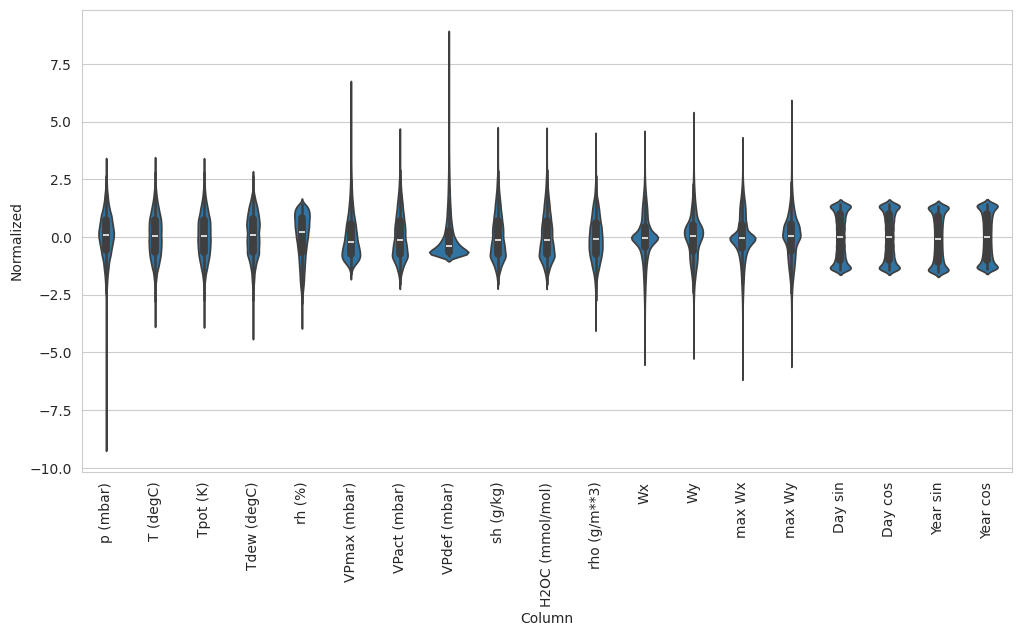

In [107]:
train_mean = train_df.mean()
train_std  = train_df.std()

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

O violin plot exibe a distribuição dos valores normalizados de cada coluna. Algumas colunas apresentam tails (caudas longas) mais pronunciadas, mas não há valores totalmente anômalos (como o antigo -9999).

Após essa inspeção, normaliza-se **cada subconjunto** (treino, validação e teste) usando `train_mean` e `train_std`:



In [108]:
def normalize(df, mean, std):
    return (df - mean) / std

#  normaliza cada subconjunto (train/val/teste) usando train_mean e train_std
train_df = normalize(train_df, train_mean, train_std)
val_df   = normalize(val_df, train_mean, train_std)
test_df  = normalize(test_df, train_mean, train_std)

print("Tamanho:")
print("  Treino:", train_df.shape)
print("  Val:", val_df.shape)
print("  Test:", test_df.shape)

Tamanho:
  Treino: (49063, 19)
  Val: (14018, 19)
  Test: (7010, 19)


> IMPORTANTE:

- Essa padronização gera dados cujos valores, por coluna, aproximam-se de uma distribuição com média 0 e desvio padrão 1 — porém **apenas** baseada nos valores de *treino*.
- Tanto `val_df` quanto `test_df` não devem influenciar as estatísticas usadas; isso garantiria um *leakage* (vazamento de informação) do futuro.

## 5.1) Por que Normalizar Usando Apenas o Treino?

1. **Simula cenário real:**
Em produção, você nunca terá acesso às estatísticas do futuro. A normalização em problemas de time series costuma sempre se basear apenas em dados históricos ou janelas móveis de dados.

2. **Evita *data leakage***:
Se as estatísticas (média e desvio) fossem calculadas em todo o dataset, os dados de validação e teste teriam fornecido informações sobre seu valor médio ou variabilidade ao modelo de alguma forma, influenciando o treino.

3. **Facilita treinamento:**
A normalização estabiliza as escalas dos atributos, ajudando os métodos de otimização (e.g. *gradient descent*) a convergirem mais rapidamente.

## 6) Classe `WindowGenerator`
O objetivo aqui é organizar os dados em janelas (ou windows) para que o modelo possa receber uma sequência de observações recentes (entradas) e produzir uma sequência ou um único valor de saída (rótulos/labels).

In [ ]:
class WindowGenerator:
    def __init__(
        self, input_width, label_width, shift,
        train_df=train_df, val_df=val_df, test_df=test_df,
        label_columns=None
    ):
        # Armazena dataframes crus
        # O construtor recebe os DataFrames de treino, validação e teste para gerar windows de cada um desses conjuntos.
        self.train_df = train_df
        self.val_df   = val_df
        self.test_df  = test_df

        # Armazena as colunas de rótulos
        self.label_columns = label_columns # lista com os nomes das colunas que queremos prever.
        if label_columns is not None: # Se não for None, a classe cria um dicionário label_columns_indices para mapear cada nome de coluna de rótulo para o índice correspondente.
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)} # mapeia todas as colunas do train_df para seus respectivos índices (0, 1, 2, ...), útil no momento de extrair as colunas corretas do batch de dados.

        # Parâmetros da janela
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width) # define o fatiamento (range) para as amostras de entrada (vai de 0 até input_width-1).
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width # marca a posição de início dos rótulos dentro de cada janela.
        self.labels_slice = slice(self.label_start, None) # define o slice final para rótulos (do label_start até o fim da janela).
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice] # são arrays com a posição exata de cada passo de entrada e saída, respectivamente.

    # permite que, ao imprimir o objeto, vejamos informações de depuração:
    # tamanho total da janela, quais índices pertencem à entrada e quais pertencem ao rótulo, e quais colunas estamos prevendo.
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])

    def split_window(self, features): #Recebe um batch de janelas, com formato (batch, total_window_size, num_features).
        inputs = features[:, self.input_slice, :] # pegamos do índice 0 até input_width-1 ao longo do eixo “tempo”.
        labels = features[:, self.labels_slice, :] # extraindo as posições do tempo que correspondem ao(s) rótulo(s).
 
        if self.label_columns is not None: #(por exemplo, ['T (degC)']), o código empilha somente essas colunas desejadas para o rótulo
            labels = tf.stack([
                labels[:, :, self.column_indices[name]] for name in self.label_columns
            ], axis=-1) 
        #Ajustando a forma (shape) para inspeção
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32) # converte o DataFrame em um array numpy, Tensor.
        ds = tf.keras.utils.timeseries_dataset_from_array( #gera um objeto tf.data.Dataset para dados de séries temporais.
            data=data,
            targets=None, #não definimos rótulos aqui, pois vamos mapeá-los depois com split_window.
            sequence_length=self.total_window_size, #o comprimento total da janela (por ex., 6 + 1 no caso de w2, ou 24 + 24 no caso de w1).
            sequence_stride=1, #cada janela começa apenas 1 passo após a anterior.
            shuffle=True, # embaralha a ordem dos exemplos para evitar correlações na ordem de treino.
            batch_size=32, # cada batch terá 32 janelas.
        )
        ds = ds.map(self.split_window) # A função self.split_window (definida anteriormente) pega cada janela (tensor) e retorna (inputs, labels) com os formatos corretos.
        return ds #é um tf.data.Dataset onde cada elemento é (inputs, labels), pronto para ser consumido pelo modelo.
    
    def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                    label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            # Rótulos (Labels)
            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)

            # Se um modelo for passado, também plota as previsões
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

### Exemplo 1
- `input_width=24:` usa 24 passos de histórico (por exemplo, 24 horas)
- `label_width=1`: prevemos 1 passo de saída (por exemplo, a temperatura no tempo t+24)
- `shift=24`: indica que o rótulo está 24 passos à frente do início da janela.

In [110]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

Ou seja, cada janela terá um tamanho total de 48 pontos no tempo, dos quais os 24 primeiros são entrada e o 48º (índice 47) é o rótulo da temperatura.

### Exemplo 2
- `input_width=6`: queremos olhar as últimas 6 horas,
- `label_width=1`: prever apenas 1 hora no futuro,
- `shift=1`: o rótulo está apenas 1 passo à frente do final da entrada.

In [111]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2


Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

Logo, cada janela de tamanho 7 contém 6 pontos como entrada e o 7º ponto (índice 6) é o rótulo.

- `w1` para previsão de 24 horas no futuro usando 24 horas de histórico.
- `w2` para previsão de 1 hora no futuro usando 6 horas de histórico.

In [ ]:
# Stack three slices, the length of the tota+l window.
example_window = tf.stack([
    np.array(train_df[:w2.total_window_size]),
    np.array(train_df[100:100+w2.total_window_size]),
    np.array(train_df[200:200+w2.total_window_size])
])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


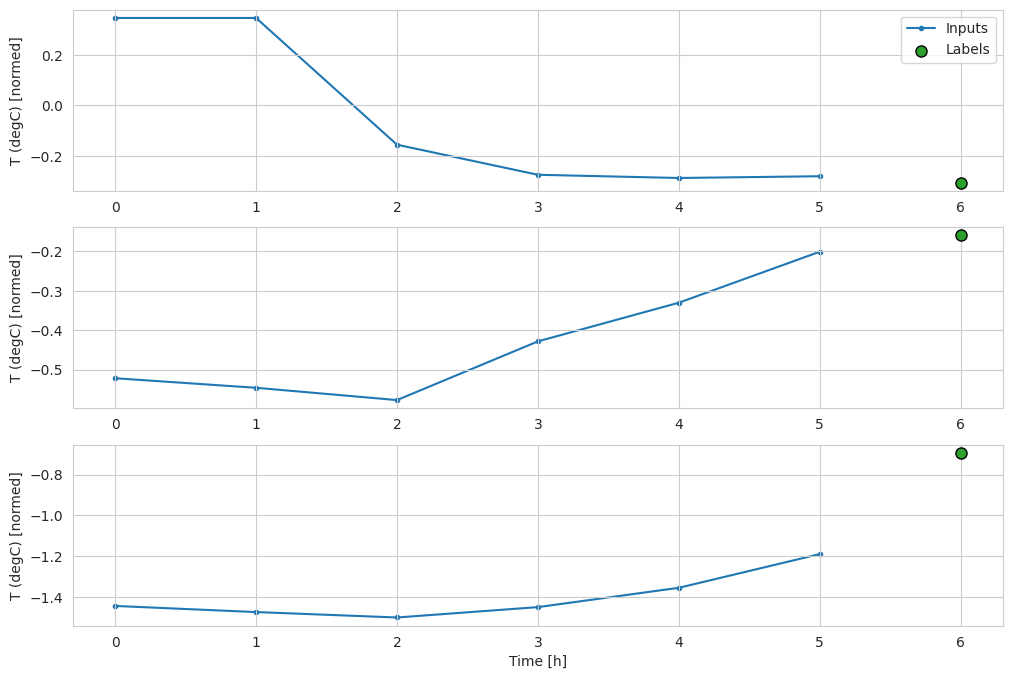

In [113]:
w2.plot()


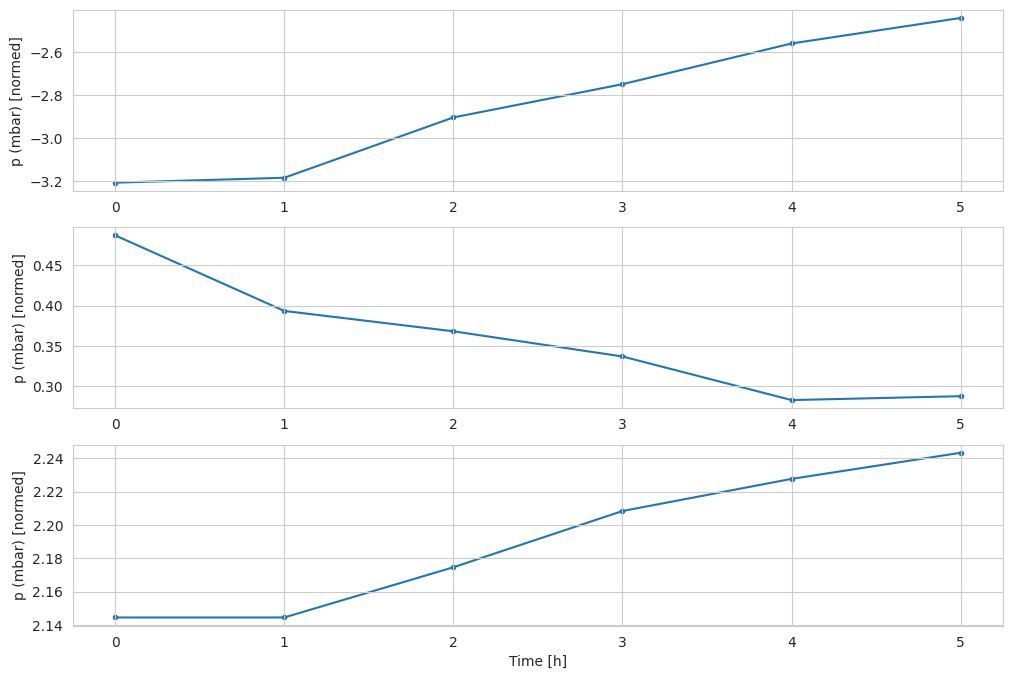

In [114]:
w2.plot(plot_col='p (mbar)')


## 7) Criação de Janelas para Previsão Multi-step
Multi-step models são abordagens em que desejamos prever vários pontos no futuro (por exemplo, as próximas 24 horas), em vez de prever apenas um único passo (uma hora à frente). 

24 horas de histórico -> 24 horas de rótulo.

Nos exemplos acima, os modelos foram treinados para prever apenas um passo no futuro — por exemplo, “qual será a temperatura daqui a 1 hora?”. Mas na prática, muitas vezes precisamos de todo o perfil do próximo período (ex.: 24 horas de previsão, não só 1).

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None
Shapes: (32, 24, 19) (32, 24, 19)


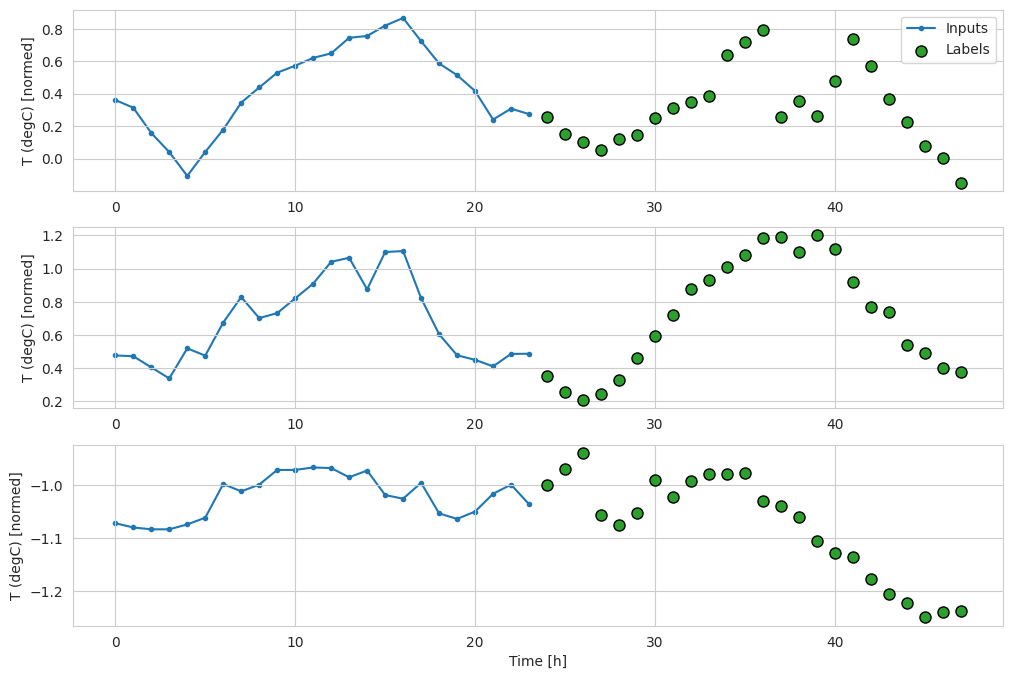

In [128]:
OUT_STEPS = 24
multi_window = WindowGenerator(
    input_width=24,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=None  # None => prever todas as colunas
)
print(multi_window)
example_inputs, example_labels = multi_window.example
print('Shapes:', example_inputs.shape, example_labels.shape)
multi_window.plot()

## 8) Modelos de Previsão
### 8.1 Função de treino (`compile_and_fit`)
Para simplificar a repetição do código.

In [129]:
def compile_and_fit(model, window, max_epochs=20, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min',
        restore_best_weights=True
    )

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['mae'] #tf.keras.metrics.MeanAbsoluteError()
    )

    history = model.fit(
        window.train,
        validation_data=window.val,
        epochs=max_epochs,
        callbacks=[early_stopping]
    )
    return history

### 8.2 Baselines (MultiStepLastBaseline, RepeatBaseline)

In [117]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        # Repete o último time step da entrada (time-1) para OUT_STEPS
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        # Repete a sequência inteira de entrada como saída (mesmo shape)
        return inputs

437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6322 - mae: 0.5023


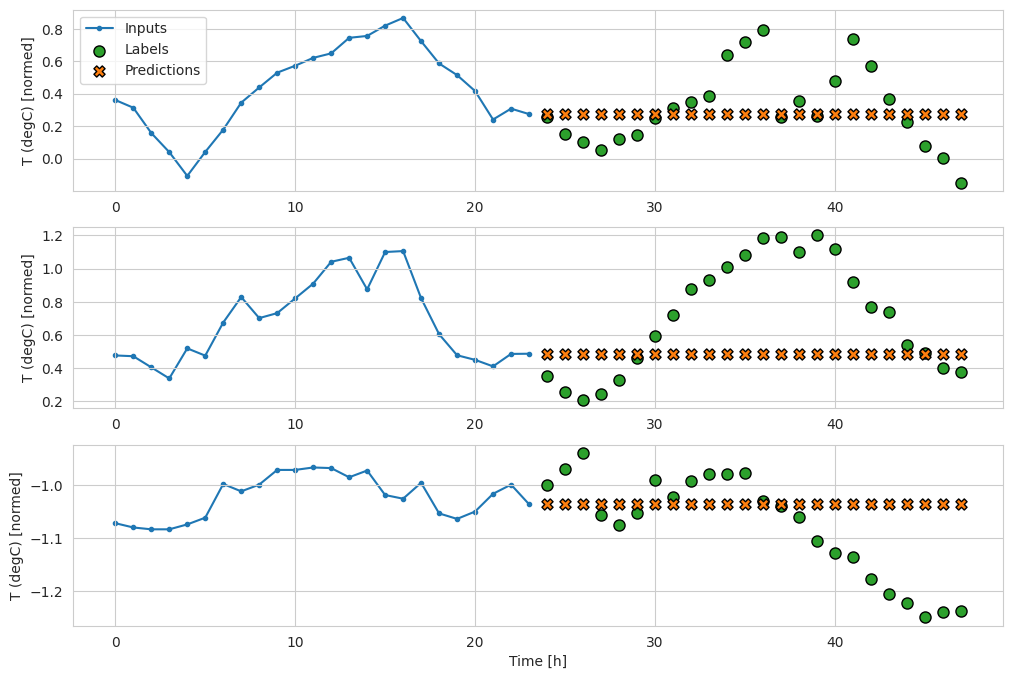

In [131]:
val_performance = {}
performance = {}

# MultiStepLastBaseline
last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss='mse', metrics=['mae'])
val_performance['Last'] = last_baseline.evaluate(multi_window.val, return_dict=True)
performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(last_baseline)


437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4233 - mae: 0.3943
Baselines - validação: {'Last': {'loss': 0.628541111946106, 'mae': 0.5007193088531494}, 'Repeat': {'loss': 0.42702537775039673, 'mae': 0.39587464928627014}}


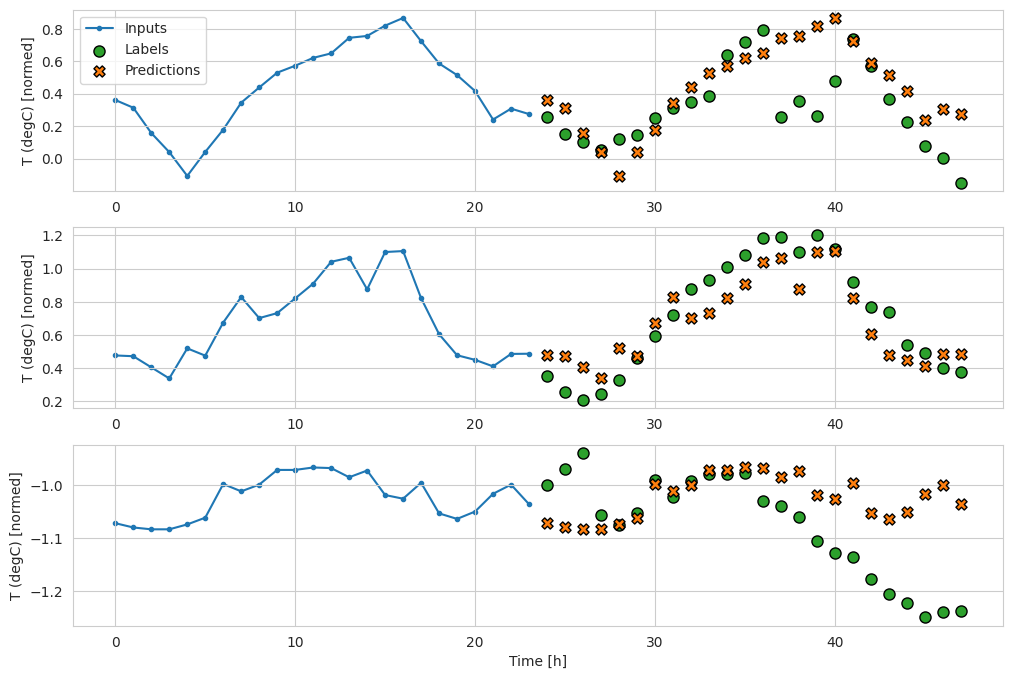

In [132]:
# RepeatBaseline
repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss='mse', metrics=['mae'])
val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val, return_dict=True)
performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0, return_dict=True)

print("Baselines - validação:", val_performance)
multi_window.plot(repeat_baseline)

### 8.3 Modelos Single-shot: Linear, Dense, CNN, LSTM

Epoch 1/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4340 - mae: 0.4784 - val_loss: 0.2597 - val_mae: 0.3234
Epoch 2/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2577 - mae: 0.3172 - val_loss: 0.2561 - val_mae: 0.3058
Epoch 3/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2560 - mae: 0.3074 - val_loss: 0.2560 - val_mae: 0.3052
Epoch 4/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2558 - mae: 0.3071 - val_loss: 0.2561 - val_mae: 0.3051
Epoch 5/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2558 - mae: 0.3070 - val_loss: 0.2560 - val_mae: 0.3053
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2570 - mae: 0.3053
Linear - val: {'loss': 0.25603318214416504, 'mae': 0.3051871061325073}


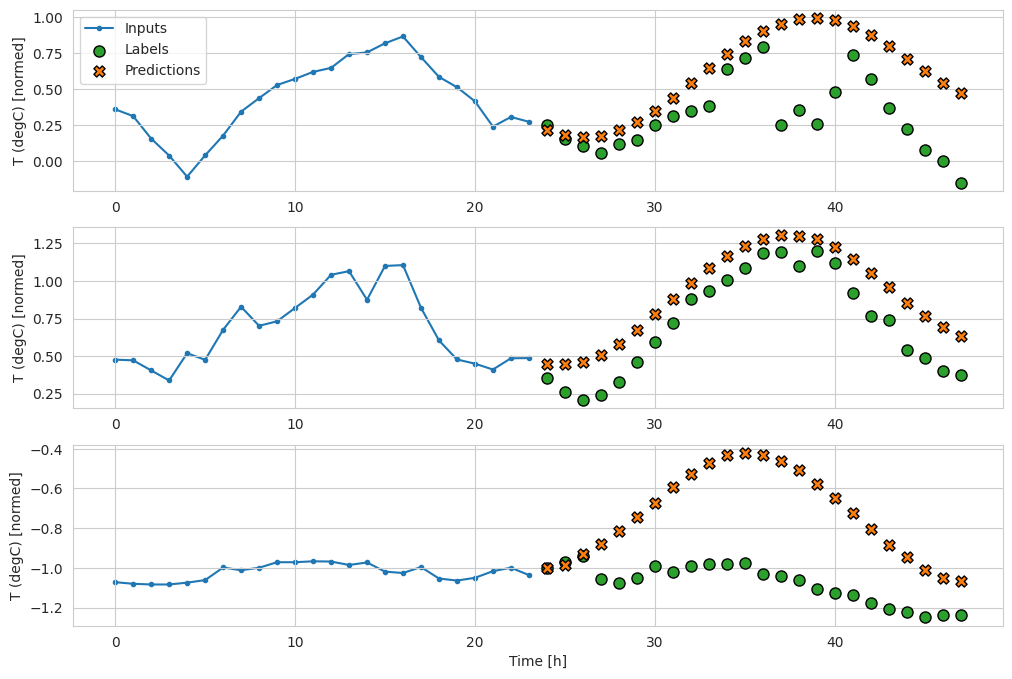

In [133]:
# 1) Linear
multi_linear_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),  # último time step
    tf.keras.layers.Dense(OUT_STEPS * train_df.shape[1], kernel_initializer=tf.zeros_initializer()),
    tf.keras.layers.Reshape([OUT_STEPS, train_df.shape[1]])
])

history = compile_and_fit(multi_linear_model, multi_window)
val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val, return_dict=True)
performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0, return_dict=True)
print("Linear - val:", val_performance['Linear'])
multi_window.plot(multi_linear_model)

Epoch 1/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.2931 - mae: 0.3492 - val_loss: 0.2268 - val_mae: 0.2884
Epoch 2/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.2249 - mae: 0.2867 - val_loss: 0.2234 - val_mae: 0.2853
Epoch 3/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.2219 - mae: 0.2839 - val_loss: 0.2219 - val_mae: 0.2843
Epoch 4/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.2196 - mae: 0.2820 - val_loss: 0.2196 - val_mae: 0.2818
Epoch 5/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.2179 - mae: 0.2805 - val_loss: 0.2201 - val_mae: 0.2829
Epoch 6/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.2167 - mae: 0.2797 - val_loss: 0.2202 - val_mae: 0.2820
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2208 - mae: 0.2829
Dense - val: {'loss': 0.21960362792015076, 'mae': 0.28182539343833923}


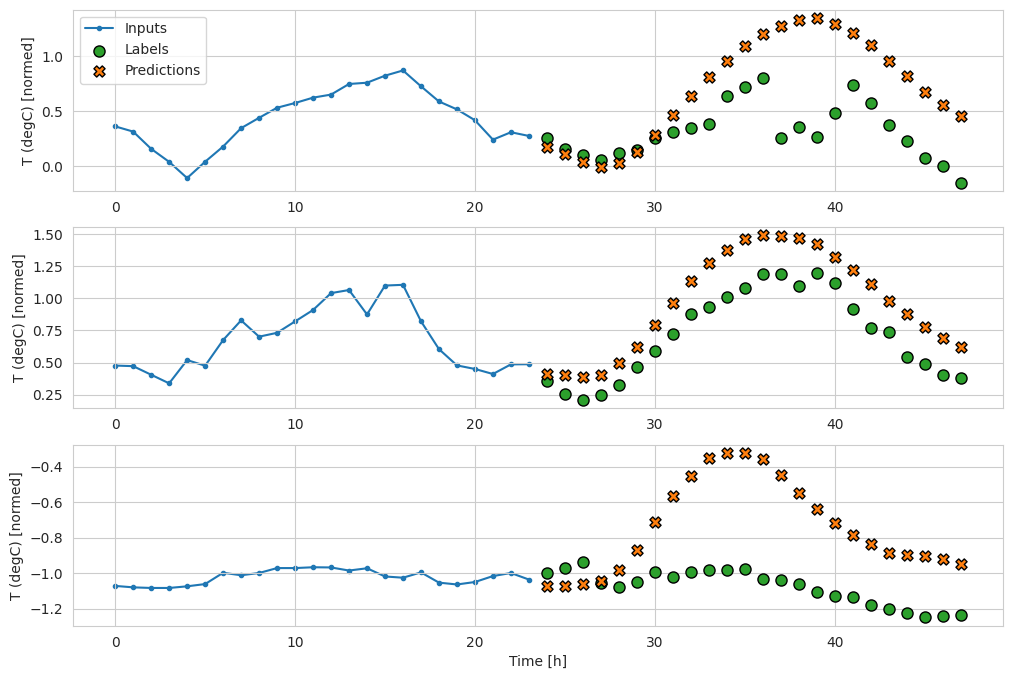

In [134]:
# 2) Dense
multi_dense_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS * train_df.shape[1], kernel_initializer=tf.zeros_initializer()),
    tf.keras.layers.Reshape([OUT_STEPS, train_df.shape[1]])
])

history = compile_and_fit(multi_dense_model, multi_window)
val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val, return_dict=True)
performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0, return_dict=True)
print("Dense - val:", val_performance['Dense'])
multi_window.plot(multi_dense_model)

Epoch 1/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3221 - mae: 0.3799 - val_loss: 0.2288 - val_mae: 0.2985
Epoch 2/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2246 - mae: 0.2939 - val_loss: 0.2248 - val_mae: 0.2930
Epoch 3/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2213 - mae: 0.2898 - val_loss: 0.2233 - val_mae: 0.2911
Epoch 4/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2194 - mae: 0.2875 - val_loss: 0.2217 - val_mae: 0.2892
Epoch 5/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2180 - mae: 0.2861 - val_loss: 0.2212 - val_mae: 0.2887
Epoch 6/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2167 - mae: 0.2845 - val_loss: 0.2191 - val_mae: 0.2857
Epoch 7/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2155 - mae: 0.2832 - val_loss: 0.2195 - val_mae: 0.2858
Epoch 8/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2148 - mae: 0.2823 - val_loss: 0.2187 - val_mae: 0.2864
Epoch 9/20
1532/1532 ━━━━━━━━━━━━━━━━━━━

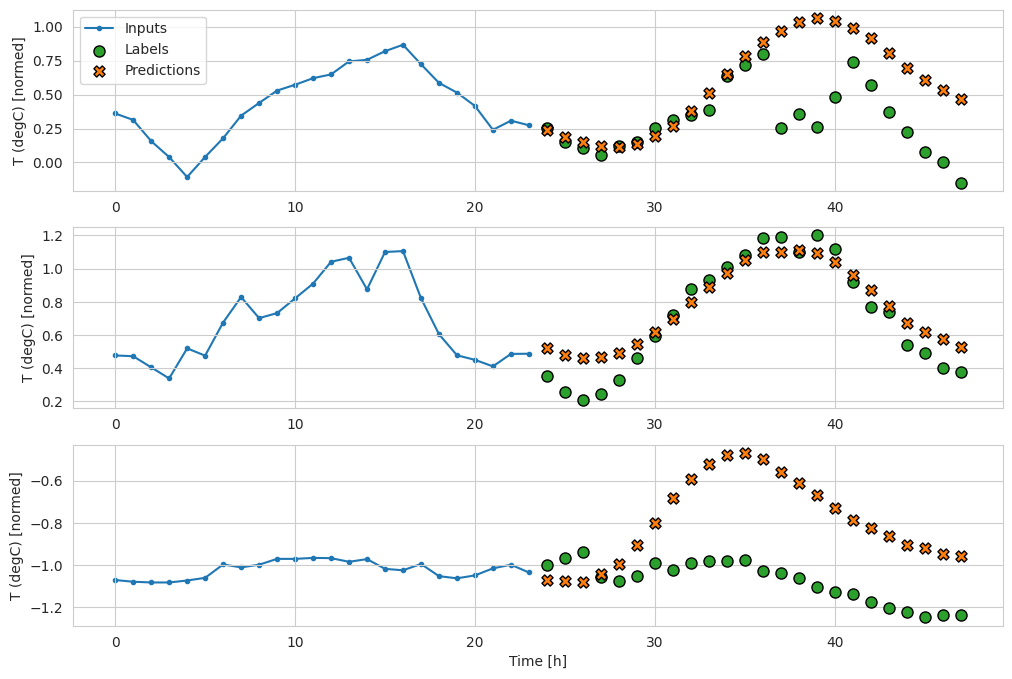

In [135]:
# 3) CNN
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(64, kernel_size=CONV_WIDTH, activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS * train_df.shape[1], kernel_initializer=tf.zeros_initializer()),
    tf.keras.layers.Reshape([OUT_STEPS, train_df.shape[1]])
])

history = compile_and_fit(multi_conv_model, multi_window)
val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val, return_dict=True)
performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0, return_dict=True)
print("CNN - val:", val_performance['Conv'])
multi_window.plot(multi_conv_model)

Epoch 1/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.4054 - mae: 0.4468 - val_loss: 0.2318 - val_mae: 0.3088
Epoch 2/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.2209 - mae: 0.2995 - val_loss: 0.2201 - val_mae: 0.2944
Epoch 3/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.2110 - mae: 0.2877 - val_loss: 0.2189 - val_mae: 0.2912
Epoch 4/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.2064 - mae: 0.2825 - val_loss: 0.2164 - val_mae: 0.2885
Epoch 5/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.2036 - mae: 0.2796 - val_loss: 0.2155 - val_mae: 0.2869
Epoch 6/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.2015 - mae: 0.2776 - val_loss: 0.2170 - val_mae: 0.2877
Epoch 7/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.1995 - mae: 0.2760 - val_loss: 0.2139 - val_mae: 0.2848
Epoch 8/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.1980 - mae: 0.2749 - val_loss: 0.2136 - val_mae: 0.2840
Epoch 9/20
1532/1532 ━━━━━━━━━━━

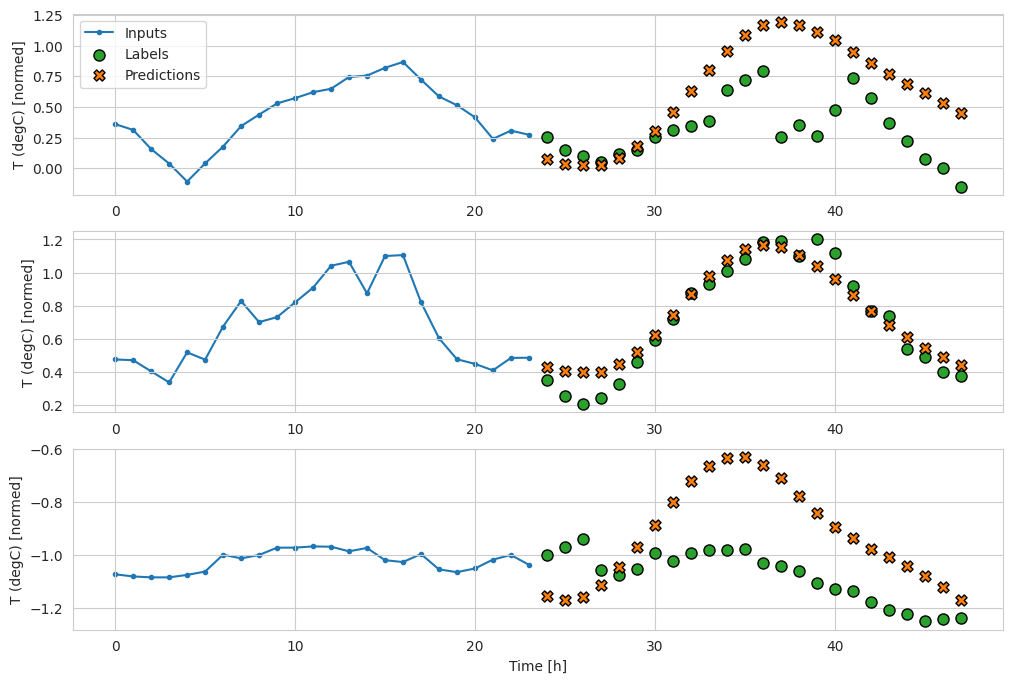

In [136]:
# 4) LSTM single-shot (return_sequences=False)
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS * train_df.shape[1], kernel_initializer=tf.zeros_initializer()),
    tf.keras.layers.Reshape([OUT_STEPS, train_df.shape[1]])
])

history = compile_and_fit(multi_lstm_model, multi_window)
val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val, return_dict=True)
performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0, return_dict=True)
print("LSTM - val:", val_performance['LSTM'])
multi_window.plot(multi_lstm_model)

### 8.4 Modelo Autoregressivo

In [137]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps, num_features):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.num_features = num_features
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
        return prediction, state

    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        predictions.append(prediction)

        for n in range(1, self.out_steps):
            x = prediction  # realimenta
            x, state = self.lstm_cell(x, states=state, training=training)
            prediction = self.dense(x)
            predictions.append(prediction)

        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

Epoch 1/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - loss: 0.4269 - mae: 0.4664 - val_loss: 0.2482 - val_mae: 0.3302
Epoch 2/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.2373 - mae: 0.3210 - val_loss: 0.2368 - val_mae: 0.3157
Epoch 3/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.2254 - mae: 0.3076 - val_loss: 0.2379 - val_mae: 0.3154
Epoch 4/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.2201 - mae: 0.3016 - val_loss: 0.2319 - val_mae: 0.3084
Epoch 5/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.2161 - mae: 0.2970 - val_loss: 0.2299 - val_mae: 0.3032
Epoch 6/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.2133 - mae: 0.2941 - val_loss: 0.2316 - val_mae: 0.3070
Epoch 7/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.2102 - mae: 0.2914 - val_loss: 0.2274 - val_mae: 0.3033
Epoch 8/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.2081 - mae: 0.2896 - val_loss: 0.2300 - val_mae: 0.3028
Epoch 9/20
1532/1532 ━━━

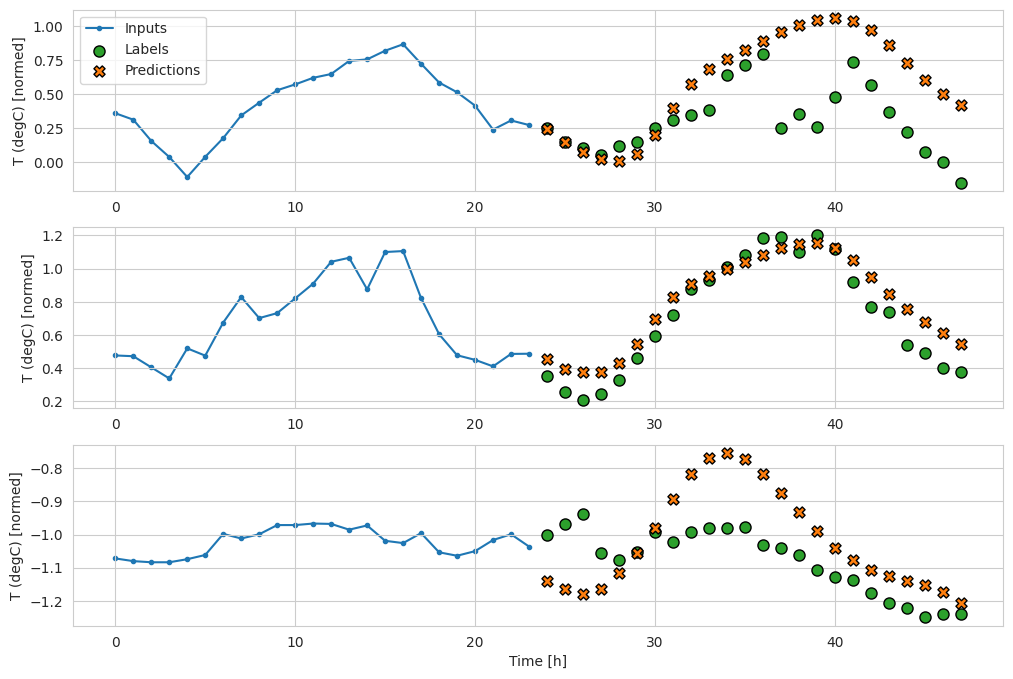

In [138]:
feedback_model = FeedBack(
    units=32,
    out_steps=OUT_STEPS,
    num_features=train_df.shape[1]
)
history = compile_and_fit(feedback_model, multi_window)

val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val, return_dict=True)
performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0, return_dict=True)
print("Autoregressive LSTM - val:", val_performance['AR LSTM'])
multi_window.plot(feedback_model)

## 9) Comparação de Resultados
Consolidamos os valores (MAE) em validação e teste.

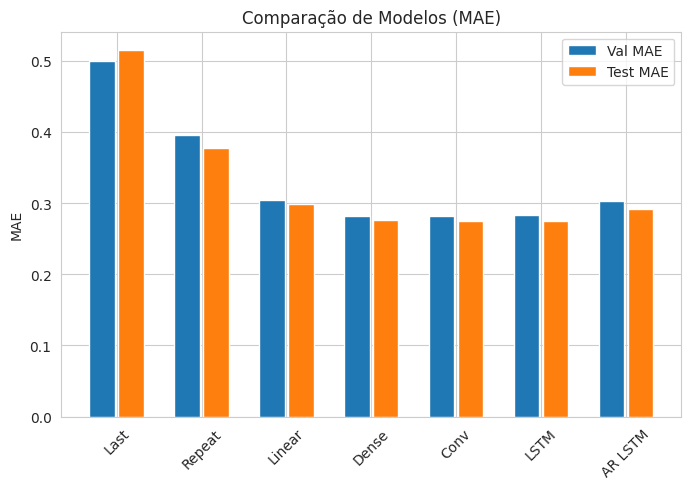

Last      : 0.5157
Repeat    : 0.3774
Linear    : 0.2986
Dense     : 0.2765
Conv      : 0.2751
LSTM      : 0.2751
AR LSTM   : 0.2922


In [141]:
import numpy as np

metric_name = 'mae'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]
model_names = list(performance.keys())

x = np.arange(len(model_names))
width = 0.3

plt.figure(figsize=(8,5))
plt.bar(x - 0.17, val_mae, width, label='Val MAE')
plt.bar(x + 0.17, test_mae, width, label='Test MAE')
plt.xticks(ticks=x, labels=model_names, rotation=45)
plt.ylabel('MAE')
plt.title('Comparação de Modelos (MAE)')
plt.legend()
plt.show()

for name, v in performance.items():
    print(f"{name:10s}: {v[metric_name]:.4f}")

## 10) Conclusão
1. **Baselines**: Podem até ser competitivos em algumas situações ("Last" ou "Repeat").
2. **Single-shot** (Linear, Dense, CNN, LSTM): Gera todas as previsões de uma só vez. Se usar apenas o último time step (caso Linear/Dense simples), perde histórico. CNN e LSTM podem captar mais contexto.
3. **Autoregressivo**: Flexível para horizontes variáveis, mas sujeito a acúmulo de erro.

### Possíveis Extensões
- Experimentar **diferentes horizontes** (ex.: 48h de entrada -> 48h de saída).
- Avaliar métricas extras (RMSE, MAPE, etc.).
- Integrar com MLflow para monitorar experimentos.
- Servir o modelo com FastAPI.

Assim concluímos um pipeline simples de **pré-processamento e previsão** de séries temporais com TensorFlow!